Simulación Modelo El Farol

In [1]:
import pandas as pd
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import redes
import ElFarolFunciones as F

En el presente modelo, se tiene una población de N individuos.

EPLICACIÓN POR NICOLÁS

#### AGENTES 
Los agentes que se simularán tendrán 4 atributos:

**Estado**: Es la acción tomada por el agente y que puede ser ir al bar (1) o abstenerse de ir (0).

**Puntaje (Score):** Puntaje obtenido. Hay tres posibilidades:

- **1** Si fue y la proporción de agentes que fueron fue menor que el $\alpha $ determinado ($\alpha=0.5$).
- **0**, si decidió no ir.
- **-1**, si fue y la proporción de agentes que fueron fue mayor que el $\alpha $ determinado ($\alpha=0.5$).

**Politica**: Es la forma en que los agentes toman la decisión de actuar en la siguiente ronda dada la situación actual, en términos de su estado y puntaje.

**Vecinos:** Los vecinos son aquellos a lo que los agentes pueden ver que decisión tomaron, y si en el caso poseen una mejor politica que los ha llevado a obtener mejors puntajes, van a decidir copiar a este.

La impementación en Python de estos atributos tiene la característica siguiente. Cada atributo se almacena como una lista, la cual guarda la información correspondiente por cada ronda. Esto es, por ejemplo, agente.estado[0] es el estado del agente en la primera ronda.

In [2]:
class agente:
    def __init__(self, estados, scores, politicas, vecinos):
        self.estado = estados # lista
        self.score = scores # lista
        self.politica = politicas # lista
        self.vecinos = vecinos

    def __str__(self):
        return "E:{0}, S:{1}, P:{2}, V{3}".format(self.estado, self.score,self.politica,self.vecinos)

Utilizando la clase **agente** podemos generar agentes aleatorios creando objetos de esta clase a los que se les asigna un estado y una política al azar. Una vez conocido el estado inicial de todos los agentes, se procede a calcular la proporción de agentes que fueron al bar, mediante la funciòn `calculamedio()`. Dependiendo de este resultado, se le asigna un puntaje a cada agente. Así pues, esta función recibe como parámetro el número de agentes que se quieren crear y retorna una lista con los agentes nuevos.

In [3]:
def crear_agentes_aleatorios(Num_agentes):
    Agentes = []
    for i in range(Num_agentes):
        Agentes.append(agente([rd.randint(0,1)], [], [rd.randint(0,7)], []))

    X = F.calcula_medio(Agentes)
    
    for a in Agentes:
        if a.estado[-1] == 1:
            if X > 0.5:
                a.score.append(-1)
            else:
                a.score.append(1)
        else:
            a.score.append(0)

    return Agentes

Recordemos que las políticas se han definido como la forma en que los agentes toman la decisión de actuar en la siguiente ronda dada la situación actual. Consideraremos un proceso de toma de decisiones muy sencillo, el cual solo usa el estado y el puntaje obtenido.

Las políticas representan la toma de decisiones de los agentes de la ronda n a la ronda n+1. En este caso, una decisión consiste en qué estrategia seguir en la ronda n+1. Para ello, cada agente consulta tanto la estrategia de la ronda n, como la recompensa obtenida.

En nuestro modelo, sólo hay tres posibles combinaciones de estrategias y recompensas, a saber:

(no ir a El Farol, recompensa 0) (ir a El Farol, recompensa 1) (ir a El Farol, recompensa -1)


In [4]:
def crear_politicas():
    politicas = [
    {(0,0): 0, (1,1): 0, (1, -1): 0}, #0
    {(0,0): 0, (1,1): 0, (1, -1): 1}, #1
    {(0,0): 0, (1,1): 1, (1, -1): 0}, #2
    {(0,0): 0, (1,1): 1, (1, -1): 1}, #3
    {(0,0): 1, (1,1): 0, (1, -1): 0}, #4
    {(0,0): 1, (1,1): 0, (1, -1): 1}, #5
    {(0,0): 1, (1,1): 1, (1, -1): 0}, #6
    {(0,0): 1, (1,1): 1, (1, -1): 1}, #7
    ]
    return politicas


In [5]:
def agentes_aprenden(Agentes):
    #Los agentes copian la politica del ganador de la Ronda
    for agente in Agentes:
        print(Agentes.index(agente))
        maximo=agente.score[-1]
        maximo_vecino=Agentes.index(agente)
        print(agente.vecinos)
        for index_vecino in agente.vecinos:
            if((Agentes[index_vecino].score[-1])>(maximo)):
                print('Hay cambio')
                print('Puntaje anterior',maximo)
                maximo=Agentes[index_vecino].score[-1]
                print('Puntaje anterior vecino',maximo)
                maximo_vecino=index_vecino
            else: print('No hay cambio')
        agente.politica.append(Agentes[maximo_vecino].politica[-1])
    return Agentes

In [6]:
def simulacion(Num_agentes, Num_iteraciones, UMBRAL, inicial, N, PARS):

    agentes = crear_agentes_aleatorios(Num_agentes)

    politicas = crear_politicas()


    # Leyendo red de archivo
    F.leer_red(agentes)

    for i in range(Num_iteraciones):
        agentes = F.juega_ronda(agentes, politicas, UMBRAL)
        agentes = agentes_aprenden(agentes)

    data = F.crea_dataframe_agentes(agentes, Num_iteraciones, PARS, N)
    print(data[1:3])
    data['Politica_lag'] = data.groupby('Agente')['Politica'].transform('shift', 1)
    data['Consistencia'] = data.apply(lambda x : F.encontrar_consistencia (x['Politica'], x['Politica_lag']), axis=1)

    # print(data.head())

    F.guardar(data, 'agentes.csv', inicial)


In [7]:
simulacion(3, 2, 0.5, 1, 0, [3, 1])

0
[]
1
[]
2
[]
0
[]
1
[]
2
[]
   Identificador  Agente  Ronda  Estado  Puntaje  Politica  Parametro-0  \
1              0       0      1       0        0         0            3   
2              0       1      0       0        0         0            3   

   Parametro-1  
1            1  
2            1  
nan <class 'numpy.float64'>
0.0 <class 'numpy.float64'>
nan <class 'numpy.float64'>
0.0 <class 'numpy.float64'>
nan <class 'numpy.float64'>
0.0 <class 'numpy.float64'>


In [16]:
import copy

# Comando para mostrar gráficos en notebook
%matplotlib inline

# Comando para leer a partir de datos
data = pd.read_csv('agentes.csv')
data.head(10)

,Identificador,Agente,Ronda,Estado,Puntaje,Politica,Parametro-0,Parametro-1,Politica_lag,Consistencia
0,0,0,0,1,-1,2,3,1,NaN,NaN
1,0,0,1,0,0,2,3,1,2.0,1.0
2,0,1,0,1,-1,3,3,1,NaN,NaN
3,0,1,1,1,-1,3,3,1,3.0,1.0
4,0,2,0,1,-1,7,3,1,NaN,NaN
5,0,2,1,1,-1,7,3,1,7.0,1.0


In [17]:
df1 = pd.DataFrame(data.groupby('Ronda')['Estado'].mean())


####  Asistencia por ronda

In [18]:
df1 = pd.DataFrame(data.groupby('Ronda')['Estado'].mean())
df1.columns = ['Asistencia']
df1.head(10)

,Asistencia
Ronda,
0,1.000000
1,0.666667


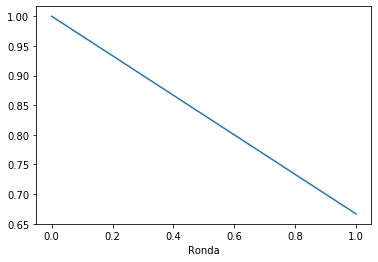

In [19]:
df1['Asistencia'].plot()

####  Puntaje promedio que obtuvo cada política vs. ronda

In [56]:
df = pd.DataFrame(data.groupby(['Ronda','Politica'])['Puntaje'].mean())\
                .reset_index()
df.head(10)

,Ronda,Politica,Puntaje
0,0,2,-1
1,0,3,-1
2,0,7,-1
3,1,2,0
4,1,3,-1
5,1,7,-1


NameError: name 'plot' is not defined

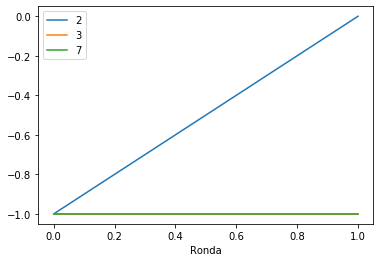

In [57]:
fig, ax = plt.subplots()
for label,group in df.groupby('Politica'):
    group.plot(x='Ronda', y='Puntaje', ax=ax,label=label)
plot.ylabel("Puntaje Promedio")

#### Uso Politica vs Ronda

In [71]:
df = pd.DataFrame(data.groupby(['Ronda','Politica'])['Agente'].count()).reset_index()
df

,Ronda,Politica,Agente
0,0,2,1
1,0,3,1
2,0,7,1
3,1,2,1
4,1,3,1
5,1,7,1


In [84]:
#Numero total de agentes
Num_agentes=df[df['Ronda']==0]['Agente'].count()

(0, 3)

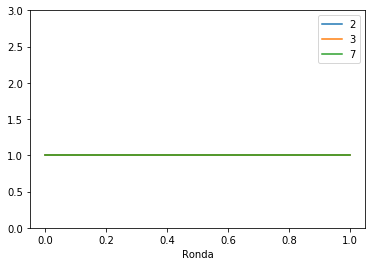

In [88]:
fig, ax = plt.subplots()
for label,group in df.groupby('Politica'):
    group.plot(x='Ronda', y='Agente', ax=ax,label=label)
ax.set_ylim([0,Num_agentes])

#### Consistencia Individual

In [90]:
df= data
df

,Identificador,Agente,Ronda,Estado,Puntaje,Politica,Parametro-0,Parametro-1,Politica_lag,Consistencia
0,0,0,0,1,-1,2,3,1,NaN,NaN
1,0,0,1,0,0,2,3,1,2.0,1.0
2,0,1,0,1,-1,3,3,1,NaN,NaN
3,0,1,1,1,-1,3,3,1,3.0,1.0
4,0,2,0,1,-1,7,3,1,NaN,NaN
5,0,2,1,1,-1,7,3,1,7.0,1.0


(-1.1, 1.1)

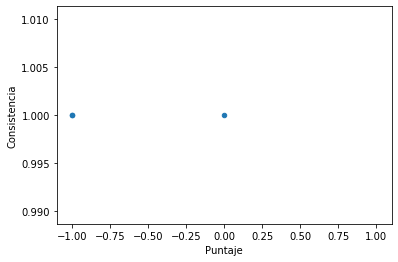

In [101]:
df.plot.scatter(x='Puntaje',y='Consistencia')
plt.xlim(-1.1,1.1)